In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd, numpy as np, os
from statsmodels.stats.weightstats import DescrStatsW
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
!pip -q install statsmodels patsy


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
PATH = '/content/drive/MyDrive/nhanes_pairA/nhanes13_14_pairA_clean.csv'
data = pd.read_csv(PATH)
print(data.shape)
data.head()


(10175, 702)


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DID330,DID341,DID350,DIQ350U,DIQ360,DIQ080,perio_modsev,sbp,dbp,hyptn
0,73557.0,8.0,2.0,1.0,69.0,NaN,4.0,4.0,1.0,NaN,...,NaN,2.0,5.397605e-79,NaN,4.0,2.0,0,112.666667,74.000000,1
1,73558.0,8.0,2.0,1.0,54.0,NaN,3.0,3.0,1.0,NaN,...,147.0,6.0,1.000000e+00,1.0,1.0,1.0,0,157.333333,61.333333,1
2,73559.0,8.0,2.0,1.0,72.0,NaN,3.0,3.0,2.0,NaN,...,6666.0,2.0,1.000000e+00,1.0,2.0,2.0,0,142.000000,82.000000,1
3,73560.0,8.0,2.0,1.0,9.0,NaN,3.0,3.0,1.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,104.666667,36.666667,0
4,73561.0,8.0,2.0,2.0,73.0,NaN,3.0,3.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,137.333333,86.666667,1


In [ ]:
df = data.copy()
# exposure: moderate+severe periodontitis(CDC/AAP status)
if "perio_modsev" not in df.columns:
    df["perio_modsev"] = df["OHDPDSTS"].isin([2, 3]).astype("int8")

# outcome: hypertension (SBP>=130 or DBP>=80 or self-reported)
if "hyptn" not in df.columns:
    df["sbp"] = df[[c for c in df.columns if c.startswith("BPXSY")]].mean(axis=1, skipna=True)
    df["dbp"] = df[[c for c in df.columns if c.startswith("BPXDI")]].mean(axis=1, skipna=True)
    df["hyptn"] = ((df["sbp"] >= 130) | (df["dbp"] >= 80) | (df["BPQ020"] == 1)).astype("int8")

#keep core survey design + covariates
keep = [
    "SEQN","perio_modsev","hyptn",
    "WTMEC2YR","SDMVPSU","SDMVSTRA",
    "RIDAGEYR","RIAGENDR","BMXBMI","SMQ020","DIQ010","RIDRETH3"
]
dat = df[keep].copy()

#nhanes periodontal exam is for adults so we'll be explicit and drop missing exposure/outcome/weight
dat = dat[(dat["RIDAGEYR"] >= 30)]
dat = dat.dropna(subset=["perio_modsev","hyptn","WTMEC2YR","SDMVPSU","SDMVSTRA","RIDAGEYR","RIAGENDR","BMXBMI","SMQ020","DIQ010"])

dat.shape


(4605, 12)

In [ ]:
pd.crosstab(dat["perio_modsev"], dat["hyptn"])


hyptn,0,1
perio_modsev,,
0,1690,2267
1,201,447


In [ ]:
def weighted_prop_and_ci(sub, y, w, alpha=0.05):
    """
    Returns proportion and normal-approx 95% CI
    """
    dsw = DescrStatsW(sub[y].astype(float), weights=sub[w].astype(float), ddof=0)
    p = dsw.mean
    se = dsw.std_mean
    z = 1.959963984540054
    lo, hi = p - z*se, p + z*se
    return p, max(0, lo), min(1, hi)

rows = []
for g, sub in dat.groupby("perio_modsev"):
    p, lo, hi = weighted_prop_and_ci(sub, y="hyptn", w="WTMEC2YR")
    rows.append({"perio_modsev": int(g), "prev": p, "lo": lo, "hi": hi})
wprev = pd.DataFrame(rows)
wprev["label"] = wprev["perio_modsev"].map({0:"None/Mild", 1:"Moderate/Severe"})
wprev


,perio_modsev,prev,lo,hi,label
0,0,0.544940,0.544864,0.545017,None/Mild
1,1,0.693006,0.692818,0.693194,Moderate/Severe


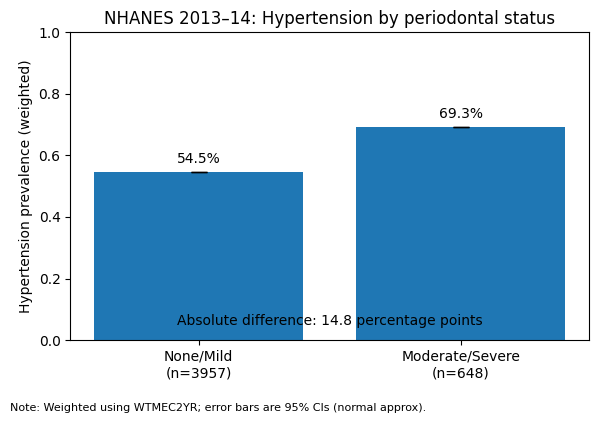

In [ ]:
#weighted prevalence bar with annotation

#unweighted sample sizes
n_none = int((dat["perio_modsev"]==0).sum())
n_mods = int((dat["perio_modsev"]==1).sum())

# pull prevalence and CI already computed into wprev
row0 = wprev[wprev["perio_modsev"]==0].iloc[0]
row1 = wprev[wprev["perio_modsev"]==1].iloc[0]

vals = [row0["prev"], row1["prev"]]
errs = [[row0["prev"]-row0["lo"], row1["prev"]-row1["lo"]],
        [row0["hi"]-row0["prev"], row1["hi"]-row1["prev"]]]
labels = [f"None/Mild\n(n={n_none})", f"Moderate/Severe\n(n={n_mods})"]

plt.figure(figsize=(6,4))
bars = plt.bar(labels, vals, yerr=errs, capsize=6)
plt.ylim(0, 1)
plt.ylabel("Hypertension prevalence (weighted)")
plt.title("NHANES 2013–14: Hypertension by periodontal status")

# percent labels
for b, v in zip(bars, vals):
    plt.text(b.get_x()+b.get_width()/2, v+0.02, f"{v*100:.1f}%", ha="center", va="bottom")

# absolute difference annotation
delta_pp = (row1["prev"] - row0["prev"]) * 100
plt.text(0.5, 0.05, f"Absolute difference: {delta_pp:.1f} percentage points",
         ha="center", transform=plt.gca().transAxes, fontsize=10)

plt.figtext(0.01, -0.04,
    "Note: Weighted using WTMEC2YR; error bars are 95% CIs (normal approx).",
    ha="left", fontsize=8)
plt.tight_layout(); plt.show()


In [ ]:
#start from the trimmed dataset 'dat' you made earlier
dat2 = dat.copy()

#recode covariates
dat2["sex"]      = dat2["RIAGENDR"].map({1:"Male", 2:"Female"})
dat2["smoker"]   = dat2["SMQ020"].map({1:"EverSmoked", 2:"NeverSmoked"})
dat2["diabetes"] = dat2["DIQ010"].map({1:"Yes", 2:"No", 3:"Yes"})   # treat 'borderline' as Yes (conservative)
dat2["race"]     = dat2["RIDRETH3"].astype("category")

# drop any remaining NAs in model vars
model_vars = ["hyptn","perio_modsev","RIDAGEYR","BMXBMI","sex","smoker","diabetes","race","WTMEC2YR"]
m = dat2.dropna(subset=model_vars).copy()

formula = "hyptn ~ perio_modsev + RIDAGEYR + BMXBMI + C(sex) + C(smoker) + C(diabetes) + C(race)"

#weighted glm (binomial) + robust (HC1) SEs
fit = smf.glm(
    formula=formula,
    data=m,
    family=sm.families.Binomial(),
    freq_weights=m["WTMEC2YR"]
).fit(cov_type="HC1")

print(fit.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  hyptn   No. Observations:                 4601
Model:                            GLM   Df Residuals:             184023384.62
Model Family:                Binomial   Df Model:                           11
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0387e+08
Date:                Mon, 25 Aug 2025   Deviance:                   2.0774e+08
Time:                        02:26:32   Pearson chi2:                 1.91e+08
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:                  HC1                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [ ]:
params = fit.params
conf   = fit.conf_int()
or_tbl = pd.DataFrame({
    "term": params.index,
    "OR": np.exp(params),
    "CI_low": np.exp(conf[0]),
    "CI_high": np.exp(conf[1]),
    "p": fit.pvalues
}).round(3)

or_tbl


,term,OR,CI_low,CI_high,p
Intercept,Intercept,0.004,0.004,0.004,0.0
C(sex)[T.Male],C(sex)[T.Male],1.286,1.285,1.287,0.0
C(smoker)[T.NeverSmoked],C(smoker)[T.NeverSmoked],0.821,0.821,0.822,0.0
C(diabetes)[T.Yes],C(diabetes)[T.Yes],2.168,2.166,2.171,0.0
C(race)[T.2.0],C(race)[T.2.0],1.100,1.098,1.102,0.0
C(race)[T.3.0],C(race)[T.3.0],1.202,1.201,1.204,0.0
C(race)[T.4.0],C(race)[T.4.0],2.233,2.230,2.237,0.0
C(race)[T.6.0],C(race)[T.6.0],1.202,1.199,1.204,0.0
C(race)[T.7.0],C(race)[T.7.0],1.531,1.527,1.534,0.0
perio_modsev,perio_modsev,1.494,1.493,1.496,0.0


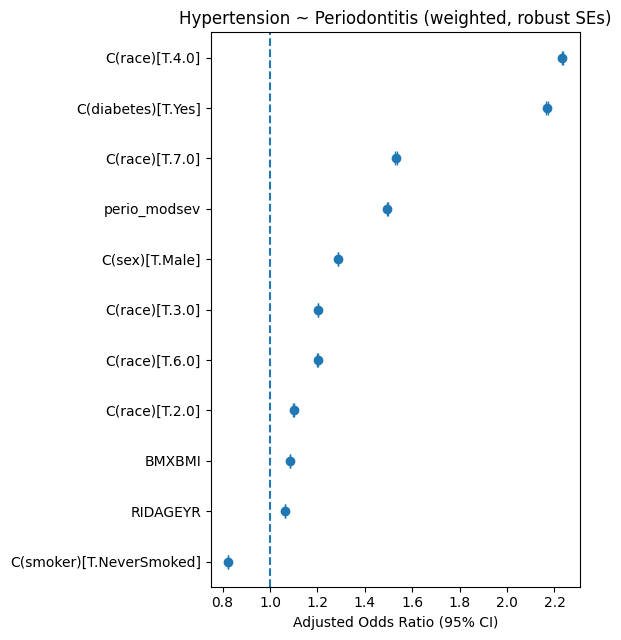

In [ ]:
plot_df = or_tbl[or_tbl["term"]!="Intercept"].copy().sort_values("OR")
y = np.arange(len(plot_df))

plt.figure(figsize=(6, 0.5*len(plot_df)+1))
plt.errorbar(plot_df["OR"], y,
             xerr=[plot_df["OR"]-plot_df["CI_low"], plot_df["CI_high"]-plot_df["OR"]],
             fmt='o', capsize=5)
plt.axvline(1.0, linestyle='--')
plt.yticks(y, plot_df["term"])
plt.xlabel("Adjusted Odds Ratio (95% CI)")
plt.title("Hypertension ~ Periodontitis (weighted, robust SEs)")
plt.tight_layout()
plt.show()


In [ ]:
# pull AOR for perio_modsev and print nicely
aor = or_tbl[or_tbl["term"]=="perio_modsev"].iloc[0]
print(f"Adjusted OR (perio_modsev vs none/mild) = {aor.OR:.2f} "
      f"(95% CI {aor.CI_low:.2f}–{aor.CI_high:.2f}, p={aor.p:.4f})")


Adjusted OR (perio_modsev vs none/mild) = 1.49 (95% CI 1.49–1.50, p=0.0000)


Predicted HTN prevalence (observed mix): 56.4%
Predicted HTN prevalence if all none/mild: 55.5%
Difference: 0.9 percentage points (~9 fewer cases per 1,000 adults)


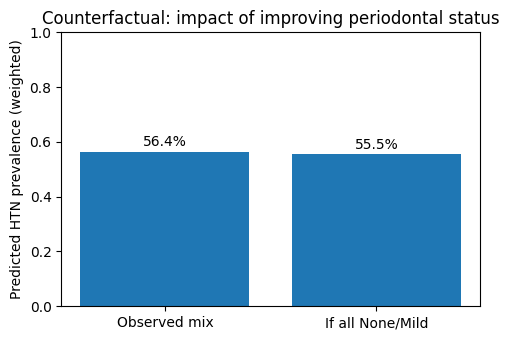

In [ ]:
# Exploring if every adult and none/mild periodontitis, how much would high BP drop

#uses the model 'fit' and data 'm' from Cell 8
W = m["WTMEC2YR"].to_numpy()

# predicted probability under observed perio mix
p_obs = fit.predict(m).to_numpy()

#predicted probability if everyone had none or mild periodontitis
p_cf  = fit.predict(m.assign(perio_modsev=0)).to_numpy()

# weighted prevalences
obs_prev = np.average(p_obs, weights=W)
cf_prev  = np.average(p_cf,  weights=W)

delta_pp = (obs_prev - cf_prev) * 100
per_1000 = delta_pp * 10

print(f"Predicted HTN prevalence (observed mix): {obs_prev*100:.1f}%")
print(f"Predicted HTN prevalence if all none/mild: {cf_prev*100:.1f}%")
print(f"Difference: {delta_pp:.1f} percentage points (~{per_1000:.0f} fewer cases per 1,000 adults)")

# bar graph to visualize observed vs counterfactual
import matplotlib.pyplot as plt
labels = ["Observed mix", "If all None/Mild"]
vals   = [obs_prev, cf_prev]
plt.figure(figsize=(5,3.5))
bars = plt.bar(labels, vals)
for b,v in zip(bars, vals):
    plt.text(b.get_x()+b.get_width()/2, v+0.02, f"{v*100:.1f}%", ha="center")
plt.ylim(0,1)
plt.ylabel("Predicted HTN prevalence (weighted)")
plt.title("Counterfactual: impact of improving periodontal status")
plt.tight_layout(); plt.show()


/tmp/ipython-input-575610365.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for band, g in m.groupby("age_band"):


AOR by age band:


,group,n,AOR,lo,hi
0,Age 30–49,1951,1.235,1.233,1.237
1,Age 50–64,1417,1.722,1.718,1.725
2,Age 65–84,1233,1.766,1.762,1.770


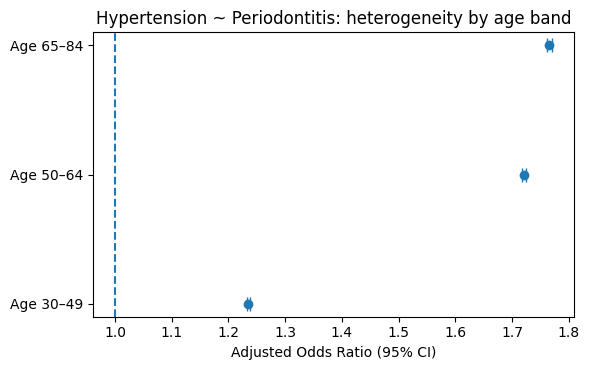

AOR by sex:


,group,n,AOR,lo,hi
0,Sex: Female,2414,1.328,1.326,1.330
1,Sex: Male,2187,1.720,1.717,1.723


In [ ]:
# Heterogeneity: AORs by age band (and by sex)

def fit_aor_subset(df):
    res = smf.glm(
        formula, data=df,
        family=sm.families.Binomial(),
        freq_weights=df["WTMEC2YR"]
    ).fit(cov_type="HC1")
    aor = np.exp(res.params["perio_modsev"])
    lo, hi = np.exp(res.conf_int().loc["perio_modsev"])
    return aor, lo, hi, len(df)

# by age bands
age_bins = pd.IntervalIndex.from_tuples([(30,50),(50,65),(65,85)], closed="left")
m["age_band"] = pd.cut(m["RIDAGEYR"], [30,50,65,85], right=False)

rows = []
for band, g in m.groupby("age_band"):
    if len(g) < 150:  # avoid unstable tiny groups
        continue
    aor, lo, hi, n = fit_aor_subset(g)
    rows.append({"group": f"Age {int(band.left)}–{int(band.right-1)}", "n": n,
                 "AOR": aor, "lo": lo, "hi": hi})
het_age = pd.DataFrame(rows).sort_values("group")
print("AOR by age band:")
display(het_age.round(3))

# quick visual
import matplotlib.pyplot as plt
plt.figure(figsize=(6,3.8))
y = np.arange(len(het_age))
plt.errorbar(het_age["AOR"], y,
             xerr=[het_age["AOR"]-het_age["lo"], het_age["hi"]-het_age["AOR"]],
             fmt='o', capsize=5)
plt.axvline(1.0, linestyle="--")
plt.yticks(y, het_age["group"])
plt.xlabel("Adjusted Odds Ratio (95% CI)")
plt.title("Hypertension ~ Periodontitis: heterogeneity by age band")
plt.tight_layout(); plt.show()

# by sex
rows = []
for sx, g in m.groupby("sex"):
    aor, lo, hi, n = fit_aor_subset(g)
    rows.append({"group": f"Sex: {sx}", "n": n, "AOR": aor, "lo": lo, "hi": hi})
het_sex = pd.DataFrame(rows)
print("AOR by sex:")
display(het_sex.round(3))


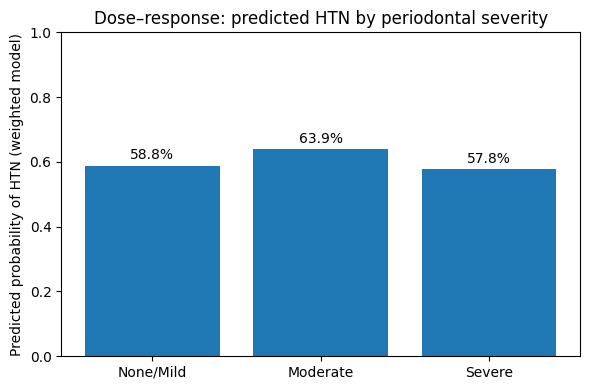

ORs (vs None/Mild):


,0
Intercept,0.003
C(OHDPDSTS)[T.2.0],0.794
C(OHDPDSTS)[T.3.0],1.615
C(sex)[T.Male],1.286
C(smoker)[T.NeverSmoked],0.821
C(diabetes)[T.Yes],2.155
C(race)[T.2.0],1.101
C(race)[T.3.0],1.205
C(race)[T.4.0],2.246
C(race)[T.6.0],1.197


In [ ]:
if "OHDPDSTS" not in dat.columns:
    dat = dat.merge(df[["SEQN","OHDPDSTS"]], on="SEQN", how="left")

m3 = dat.dropna(subset=["OHDPDSTS","WTMEC2YR","RIDAGEYR","BMXBMI",
                        "RIAGENDR","SMQ020","DIQ010","RIDRETH3","hyptn"]).copy()
m3["sex"]      = m3["RIAGENDR"].map({1:"Male", 2:"Female"})
m3["smoker"]   = m3["SMQ020"].map({1:"EverSmoked", 2:"NeverSmoked"})
m3["diabetes"] = m3["DIQ010"].map({1:"Yes", 2:"No", 3:"Yes"})
m3["race"]     = m3["RIDRETH3"].astype("category")

fit3 = smf.glm(
    "hyptn ~ C(OHDPDSTS) + RIDAGEYR + BMXBMI + C(sex) + C(smoker) + C(diabetes) + C(race)",
    data=m3, family=sm.families.Binomial(), freq_weights=m3["WTMEC2YR"]
).fit(cov_type="HC1")

pred = fit3.get_prediction(m3).summary_frame()["mean"]
m3["pred"] = pred
pp = m3.groupby("OHDPDSTS")["pred"].mean().rename({1:"None/Mild", 2:"Moderate", 3:"Severe"})

plt.figure(figsize=(6,4))
plt.bar(pp.index, pp.values)
for i,v in enumerate(pp.values): plt.text(i, v+0.02, f"{v*100:.1f}%", ha="center")
plt.ylim(0,1); plt.ylabel("Predicted probability of HTN (weighted model)")
plt.title("Dose–response: predicted HTN by periodontal severity")
plt.tight_layout(); plt.show()

print("ORs (vs None/Mild):")
display(np.exp(fit3.params).round(3))


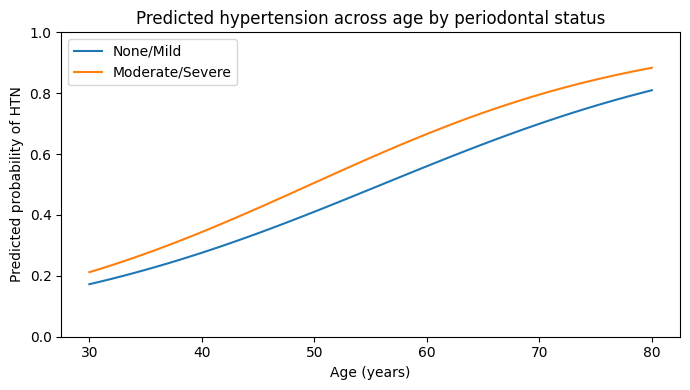

In [ ]:
dat2 = dat.copy()
dat2["sex"]      = dat2["RIAGENDR"].map({1:"Male", 2:"Female"})
dat2["smoker"]   = dat2["SMQ020"].map({1:"EverSmoked", 2:"NeverSmoked"})
dat2["diabetes"] = dat2["DIQ010"].map({1:"Yes", 2:"No", 3:"Yes"})
dat2["race"]     = dat2["RIDRETH3"].astype("category")
dat2["age_c"]    = dat2["RIDAGEYR"] - dat2["RIDAGEYR"].mean()

fit_int = smf.glm(
    "hyptn ~ perio_modsev*age_c + BMXBMI + C(sex) + C(smoker) + C(diabetes) + C(race)",
    data=dat2, family=sm.families.Binomial(), freq_weights=dat2["WTMEC2YR"]
).fit(cov_type="HC1")

age_grid = np.arange(30, 81)
def pred_for(group):
    tmp = pd.DataFrame({
        "perio_modsev": group,
        "age_c": age_grid - dat2["RIDAGEYR"].mean(),
        "BMXBMI": dat2["BMXBMI"].median(),
        "sex": "Female", "smoker": "NeverSmoked", "diabetes": "No",
        "race": dat2["race"].mode()[0]
    })
    return fit_int.get_prediction(tmp).summary_frame()["mean"].to_numpy()

p0, p1 = pred_for(0), pred_for(1)
plt.figure(figsize=(7,4))
plt.plot(age_grid, p0, label="None/Mild")
plt.plot(age_grid, p1, label="Moderate/Severe")
plt.ylim(0,1); plt.xlabel("Age (years)"); plt.ylabel("Predicted probability of HTN")
plt.title("Predicted hypertension across age by periodontal status")
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
# wanted to check the old 140/90 classic threshold out of curiousity

#build SBP/DBP from the big df
bp = df[["SEQN"] + [c for c in df.columns if c.startswith(("BPXSY","BPXDI"))]].copy()
bp["sbp"] = df[[c for c in df.columns if c.startswith("BPXSY")]].mean(axis=1)
bp["dbp"] = df[[c for c in df.columns if c.startswith("BPXDI")]].mean(axis=1)

#merge with analysis dataset
m2 = dat.merge(bp[["SEQN","sbp","dbp"]], on="SEQN", how="left").dropna(subset=["sbp","dbp"]).copy()

# creating alternative HTN outcome (140/90 OR prior dx)
m2["hyptn_14090"] = ((m2["sbp"]>=140) | (m2["dbp"]>=90) | (m2["hyptn"]==1)).astype(int)

# recreate the categorical covariates used in the formula
m2["sex"]      = m2["RIAGENDR"].map({1:"Male", 2:"Female"})
m2["smoker"]   = m2["SMQ020"].map({1:"EverSmoked", 2:"NeverSmoked"})
m2["diabetes"] = m2["DIQ010"].map({1:"Yes", 2:"No", 3:"Yes"})  # treat 'borderline' as Yes
m2["race"]     = m2["RIDRETH3"].astype("category")

# fit the weighted GLM with robust SEs
model_vars = ["hyptn_14090","perio_modsev","RIDAGEYR","BMXBMI","sex","smoker","diabetes","race","WTMEC2YR"]
m2m = m2.dropna(subset=model_vars)

fit2 = smf.glm(
    "hyptn_14090 ~ perio_modsev + RIDAGEYR + BMXBMI + C(sex) + C(smoker) + C(diabetes) + C(race)",
    data=m2m, family=sm.families.Binomial(), freq_weights=m2m["WTMEC2YR"]
).fit(cov_type="HC1")

or2 = np.exp(fit2.params["perio_modsev"])
ci2 = np.exp(fit2.conf_int().loc["perio_modsev"])
print(f"Sensitivity AOR = {or2:.2f} (95% CI {ci2[0]:.2f}–{ci2[1]:.2f})")


Sensitivity AOR = 1.64 (95% CI 1.64–1.65)


AUC baseline = 0.789  |  +periodontitis = 0.793  (Δ = 0.004)


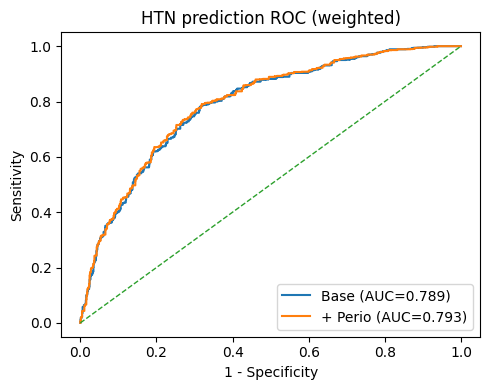

In [ ]:
# ROC/AUC comparison (baseline vs + periodontitis)
# Purpose is to show predictive lift when adding the perio flag

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#design matrices
X_base = pd.get_dummies(m[["RIDAGEYR","BMXBMI","sex","smoker","diabetes","race"]], drop_first=True)
X_plus = X_base.join(m["perio_modsev"])
y = m["hyptn"]
w = m["WTMEC2YR"]

# consistent split(same indices for both models)
idx_tr, idx_te = train_test_split(m.index, test_size=0.30, random_state=42, stratify=y)

def fit_and_auc(X):
    pipe = make_pipeline(StandardScaler(with_mean=False),
                         LogisticRegression(max_iter=1000))
    pipe.fit(X.loc[idx_tr], y.loc[idx_tr],
             logisticregression__sample_weight=w.loc[idx_tr])
    pred = pipe.predict_proba(X.loc[idx_te])[:,1]
    auc  = roc_auc_score(y.loc[idx_te], pred, sample_weight=w.loc[idx_te])
    fpr, tpr, _ = roc_curve(y.loc[idx_te], pred, sample_weight=w.loc[idx_te])
    return auc, fpr, tpr, pipe

auc_base, fpr0, tpr0, pipe0 = fit_and_auc(X_base)
auc_plus, fpr1, tpr1, pipe1 = fit_and_auc(X_plus)

print(f"AUC baseline = {auc_base:.3f}  |  +periodontitis = {auc_plus:.3f}  (Δ = {auc_plus-auc_base:.3f})")

plt.figure(figsize=(5,4))
plt.plot(fpr0, tpr0, label=f"Base (AUC={auc_base:.3f})")
plt.plot(fpr1, tpr1, label=f"+ Perio (AUC={auc_plus:.3f})")
plt.plot([0,1],[0,1],'--', lw=1)
plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity")
plt.title("HTN prediction ROC (weighted)"); plt.legend(); plt.tight_layout(); plt.show()


,feature,coef,OR
0,RIDAGEYR,0.858130,2.358746
1,BMXBMI,0.550355,1.733869
7,race_4.0,0.296730,1.345452
4,diabetes_Yes,0.277249,1.319494
2,sex_Male,0.119840,1.127316
3,smoker_NeverSmoked,-0.119819,0.887081
10,perio_modsev,0.109815,1.116072
8,race_6.0,0.049375,1.050614
6,race_3.0,0.030160,1.030620
9,race_7.0,0.027547,1.027929


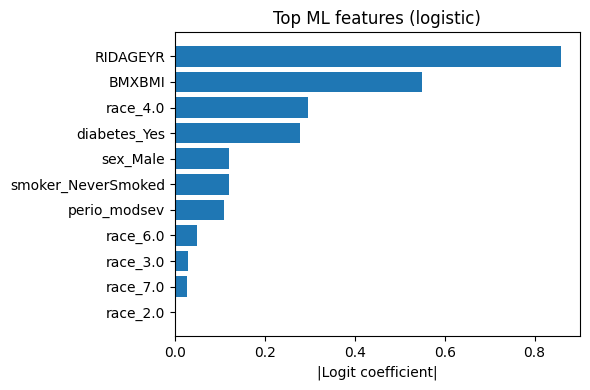

Perio feature is among top predictors in the ML model.


In [ ]:
# Coefficients from the +perio model (top absolute effects)
import numpy as np
coef = pipe1.named_steps["logisticregression"].coef_.ravel()
feat = X_plus.columns.to_numpy()
coef_df = (pd.DataFrame({"feature": feat, "coef": coef})
             .assign(OR = np.exp(coef))
             .reindex(np.argsort(-np.abs(coef)))
             .head(12))
display(coef_df)

# quick bar of absolute coefficients
plt.figure(figsize=(6,4))
plt.barh(coef_df["feature"][::-1], np.abs(coef_df["coef"])[::-1])
plt.xlabel("|Logit coefficient|"); plt.title("Top ML features (logistic)"); plt.tight_layout(); plt.show()

# call-out:
if "perio_modsev" in coef_df["feature"].values:
    print("Perio feature is among top predictors in the ML model.")
else:
    print("Perio feature has modest predictive contribution relative to age/BMI/etc.")


   perio_modsev  mean_bmi     lo     hi     n            label
0             0     29.41  29.41  29.41  3957        None/Mild
1             1     30.20  30.20  30.21   648  Moderate/Severe


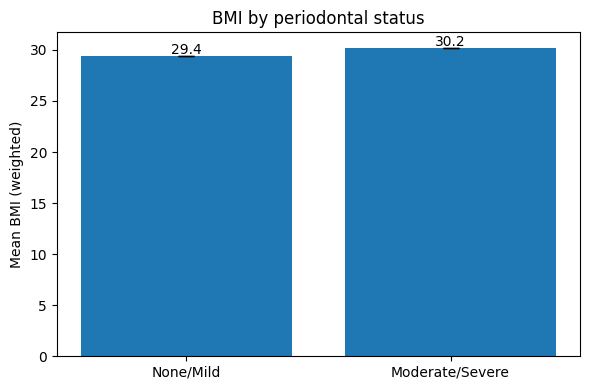

In [ ]:
# Weighted mean BMI by periodontal status + CI
from statsmodels.stats.weightstats import DescrStatsW
rows = []
for g, sub in dat.groupby("perio_modsev"):
    d = sub.dropna(subset=["BMXBMI","WTMEC2YR"])
    dsw = DescrStatsW(d["BMXBMI"].astype(float), weights=d["WTMEC2YR"].astype(float), ddof=0)
    mean = dsw.mean; se = dsw.std_mean; z = 1.959963984540054
    lo, hi = mean - z*se, mean + z*se
    rows.append({"perio_modsev": int(g), "mean_bmi": mean, "lo": lo, "hi": hi, "n": len(d)})

bmi_tbl = (pd.DataFrame(rows)
           .assign(label=lambda x: x["perio_modsev"].map({0:"None/Mild", 1:"Moderate/Severe"})))
print(bmi_tbl.round(2))

# quick bar plot
import matplotlib.pyplot as plt
vals = bmi_tbl["mean_bmi"].values
errs = [vals - bmi_tbl["lo"].values, bmi_tbl["hi"].values - vals]
plt.figure(figsize=(6,4))
plt.bar(bmi_tbl["label"], vals, yerr=errs, capsize=6)
for i,v in enumerate(vals): plt.text(i, v+0.2, f"{v:.1f}", ha="center")
plt.ylabel("Mean BMI (weighted)"); plt.title("BMI by periodontal status")
plt.tight_layout(); plt.show()

In [ ]:
# BMI ~ perio (adjusted). Gaussian GLM with weights + robust SEs
dat_b = dat.dropna(subset=["BMXBMI","perio_modsev","RIDAGEYR","RIAGENDR","SMQ020","DIQ010","RIDRETH3","WTMEC2YR"]).copy()
dat_b["sex"]      = dat_b["RIAGENDR"].map({1:"Male", 2:"Female"})
dat_b["smoker"]   = dat_b["SMQ020"].map({1:"EverSmoked", 2:"NeverSmoked"})
dat_b["diabetes"] = dat_b["DIQ010"].map({1:"Yes", 2:"No", 3:"Yes"})
dat_b["race"]     = dat_b["RIDRETH3"].astype("category")

fit_bmi = smf.glm(
    "BMXBMI ~ perio_modsev + RIDAGEYR + C(sex) + C(smoker) + C(diabetes) + C(race)",
    data=dat_b, family=sm.families.Gaussian(), freq_weights=dat_b["WTMEC2YR"]
).fit(cov_type="HC1")

coef = fit_bmi.params["perio_modsev"]; ci = fit_bmi.conf_int().loc["perio_modsev"]
print(f"Adjusted difference in BMI (mod/sev vs none/mild): {coef:.2f} (95% {ci[0]:.2f}–{ci[1]:.2f})")


Adjusted difference in BMI (mod/sev vs none/mild): 0.68 (95% 0.68–0.69)


In [ ]:
# recode diabetes, show weighted diabetes prevalence by perio group and fit a weighted logistic model of periodontitis ~BMI + diabetes + covariates.


# DIQ010 codes: 1=Yes, 2=No, 3=Borderline (treat as Yes). Others (7/9/77/99) -> NA and dropped.
valid_dm = [1, 2, 3]

dat_d = dat.dropna(subset=["perio_modsev", "WTMEC2YR"]).copy()
dat_d.loc[~dat_d["DIQ010"].isin(valid_dm), "DIQ010"] = np.nan
dat_d = dat_d.dropna(subset=["DIQ010"]).copy()

# Binary diabetes 0/1 for prevalence calc
dat_d["diabetes"] = dat_d["DIQ010"].map({1: 1, 2: 0, 3: 1}).astype("int8")

# 2) Weighted diabetes prevalence by perio group
rows = []
for g, sub in dat_d.groupby("perio_modsev"):
    dsw = DescrStatsW(sub["diabetes"].astype(float),
                      weights=sub["WTMEC2YR"].astype(float),
                      ddof=0)
    rows.append({
        "perio_modsev": int(g),
        "weighted_diabetes_prevalence": dsw.mean,
        "n_unweighted": len(sub)
    })
dm_prev = pd.DataFrame(rows)
print("\nWeighted diabetes prevalence by periodontal status:")
display(dm_prev)

# 3) Model: perio_modsev ~ BMI + diabetes + covariates (weighted)
m_perio = dat.dropna(subset=[
    "perio_modsev","BMXBMI","DIQ010","RIDAGEYR","RIAGENDR",
    "SMQ020","RIDRETH3","WTMEC2YR"
]).copy()

# keep valid diabetes codes and recode
m_perio = m_perio[m_perio["DIQ010"].isin(valid_dm)].copy()
m_perio["diabetes"] = m_perio["DIQ010"].map({1: "Yes", 2: "No", 3: "Yes"}).astype("category")

# recode other covariates
m_perio["sex"]    = m_perio["RIAGENDR"].map({1: "Male", 2: "Female"})
m_perio["smoker"] = m_perio["SMQ020"].map({1: "EverSmoked", 2: "NeverSmoked"})
m_perio["race"]   = m_perio["RIDRETH3"].astype("category")

fit_perio = smf.glm(
    "perio_modsev ~ BMXBMI + C(diabetes) + RIDAGEYR + C(sex) + C(smoker) + C(race)",
    data=m_perio,
    family=sm.families.Binomial(),
    freq_weights=m_perio["WTMEC2YR"]
).fit(cov_type="HC1")

# 4) Report effects (ORs)
# BMI reported per +5 kg/m^2
bmi_coef = fit_perio.params["BMXBMI"]
bmi_ci   = fit_perio.conf_int().loc["BMXBMI"]
or_bmi5  = np.exp(5 * bmi_coef)
ci_bmi5  = np.exp(5 * bmi_ci)

print(f"\nOdds of moderate/severe periodontitis per +5 BMI: "
      f"{or_bmi5:.2f} (95% {ci_bmi5[0]:.2f}–{ci_bmi5[1]:.2f})")

# Diabetes Yes vs No
dm_term = "C(diabetes)[T.Yes]"
if dm_term in fit_perio.params.index:
    or_dm = np.exp(fit_perio.params[dm_term])
    ci_dm = np.exp(fit_perio.conf_int().loc[dm_term])
    print(f"Odds of moderate/severe periodontitis for diabetes (Yes vs No): "
          f"{or_dm:.2f} (95% {ci_dm[0]:.2f}–{ci_dm[1]:.2f})")
else:
    print("Diabetes term not found in the model (check coding).")

# full OR table
or_tbl = (pd.DataFrame({
    "term": fit_perio.params.index,
    "OR": np.exp(fit_perio.params),
    "CI_low": np.exp(fit_perio.conf_int()[0]),
    "CI_high": np.exp(fit_perio.conf_int()[1]),
    "p": fit_perio.pvalues
}).round(3))

print("\nModel terms as odds ratios:")
display(or_tbl)



Weighted diabetes prevalence by periodontal status:


,perio_modsev,weighted_diabetes_prevalence,n_unweighted
0,0,0.149039,3955
1,1,0.205825,647



Odds of moderate/severe periodontitis per +5 BMI: 1.08 (95% 1.08–1.08)
Odds of moderate/severe periodontitis for diabetes (Yes vs No): 1.15 (95% 1.15–1.15)

Model terms as odds ratios:


,term,OR,CI_low,CI_high,p
Intercept,Intercept,0.040,0.040,0.040,0.0
C(diabetes)[T.Yes],C(diabetes)[T.Yes],1.153,1.151,1.154,0.0
C(sex)[T.Male],C(sex)[T.Male],0.683,0.682,0.683,0.0
C(smoker)[T.NeverSmoked],C(smoker)[T.NeverSmoked],0.900,0.899,0.901,0.0
C(race)[T.2.0],C(race)[T.2.0],0.694,0.692,0.696,0.0
C(race)[T.3.0],C(race)[T.3.0],0.665,0.664,0.666,0.0
C(race)[T.4.0],C(race)[T.4.0],0.944,0.942,0.946,0.0
C(race)[T.6.0],C(race)[T.6.0],0.989,0.986,0.991,0.0
C(race)[T.7.0],C(race)[T.7.0],0.419,0.417,0.421,0.0
BMXBMI,BMXBMI,1.015,1.015,1.016,0.0
